## Problem Statement

You need to build a model that is able to classify customer complaints based on the products/services. By doing so, you can segregate these tickets into their relevant categories and, therefore, help in the quick resolution of the issue.

You will be doing topic modelling on the <b>.json</b> data provided by the company. Since this data is not labelled, you need to apply NMF to analyse patterns and classify tickets into the following five clusters based on their products/services:

* Credit card / Prepaid card

* Bank account services

* Theft/Dispute reporting

* Mortgages/loans

* Others


With the help of topic modelling, you will be able to map each ticket onto its respective department/category. You can then use this data to train any supervised model such as logistic regression, decision tree or random forest. Using this trained model, you can classify any new customer complaint support ticket into its relevant department.

## Pipelines that needs to be performed:

You need to perform the following eight major tasks to complete the assignment:

1.  Data loading

2. Text preprocessing

3. Exploratory data analysis (EDA)

4. Feature extraction

5. Topic modelling

6. Model building using supervised learning

7. Model training and evaluation

8. Model inference

## Importing the necessary libraries

In [4]:
! pip install swifter

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 6.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for swifter: filename=swifter-1.4.0-py3-none-any.whl size=16507 sha256=8c3dc5e0cfe7fe3fa95b0391674a81f43adfbe6b10510e151709c9a7e8d74773
  Stored in directory: /root/.cache/pip/wheels/e4/cf/51/0904952972ee2c7aa3709437065278dc534ec1b8d2ad41b443
Successfully built swifter


In [5]:
import json
import numpy as np
import tensorflow as tf
import pathlib
import pandas as pd
import re, nltk, spacy, string
import en_core_web_sm
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB

from sklearn.metrics import classification_report
from sklearn.decomposition import NMF
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV

from plotly.offline import plot
import plotly.graph_objects as go
import pickle
import plotly.express as px

from textblob import TextBlob
from wordcloud import WordCloud, STOPWORDS
from pprint import pprint

%matplotlib inline
nlp = en_core_web_sm.load()

In [6]:
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

## Loading the data

The data is in JSON format and we need to convert it to a dataframe.

In [7]:
dataset_url = "https://drive.google.com/u/0/uc?id=1Y4Yzh1uTLIBLnJq1_QvoosFx9giiR1_K&export=download&confirm=t"
archive = tf.keras.utils.get_file(origin=dataset_url, extract=True)
data_dir = pathlib.Path(archive).with_suffix('')

83392514/83392514 [==============================] - 1s 0us/step


In [8]:
!mv  /root/.keras/datasets/uc /content/dataset
data_dir = pathlib.Path("/content/dataset.json").with_suffix('')


In [9]:
f = open(data_dir)
data = json.load(f)
df=pd.json_normalize(data)

## Data preparation

In [10]:
# Inspect the dataframe to understand the given data.
df.head()

,_index,_type,_id,_score,_source.tags,_source.zip_code,_source.complaint_id,_source.issue,_source.date_received,_source.state,...,_source.company_response,_source.company,_source.submitted_via,_source.date_sent_to_company,_source.company_public_response,_source.sub_product,_source.timely,_source.complaint_what_happened,_source.sub_issue,_source.consumer_consent_provided
0,complaint-public-v2,complaint,3211475,0.0,None,90301,3211475,Attempts to collect debt not owed,2019-04-13T12:00:00-05:00,CA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-13T12:00:00-05:00,None,Credit card debt,Yes,,Debt is not yours,Consent not provided
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Problem with rewards from credit card,Consent provided
3,complaint-public-v2,complaint,2673060,0.0,None,48066,2673060,Trouble during payment process,2017-09-13T12:00:00-05:00,MI,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2017-09-14T12:00:00-05:00,None,Conventional home mortgage,Yes,,None,Consent not provided
4,complaint-public-v2,complaint,3203545,0.0,None,10473,3203545,Fees or interest,2019-04-05T12:00:00-05:00,NY,...,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-04-05T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,,Charged too much interest,N/A


In [11]:
#print the column names
print("Data Information")
print(f"columns : ",df.columns)
print(f"shape : ",df.shape)

Data Information
columns :  Index(['_index', '_type', '_id', '_score', '_source.tags', '_source.zip_code',
       '_source.complaint_id', '_source.issue', '_source.date_received',
       '_source.state', '_source.consumer_disputed', '_source.product',
       '_source.company_response', '_source.company', '_source.submitted_via',
       '_source.date_sent_to_company', '_source.company_public_response',
       '_source.sub_product', '_source.timely',
       '_source.complaint_what_happened', '_source.sub_issue',
       '_source.consumer_consent_provided'],
      dtype='object')
shape :  (78313, 22)


In [12]:
#Assign new column names
def colname(x):
  if len(x.split(".")) == 2:
    return x.split(".")[1]
  else:
    return x[1:]

newcolumns = {column:  colname(column) for column in df.columns.tolist()}
data = df.rename(columns = newcolumns)
print(f"After renaming the columns of the DataFrame")
print(f"Columns : ",data.columns)
print(f"Shape : ",data.shape)

After renaming the columns of the DataFrame
Columns :  Index(['index', 'type', 'id', 'score', 'tags', 'zip_code', 'complaint_id',
       'issue', 'date_received', 'state', 'consumer_disputed', 'product',
       'company_response', 'company', 'submitted_via', 'date_sent_to_company',
       'company_public_response', 'sub_product', 'timely',
       'complaint_what_happened', 'sub_issue', 'consumer_consent_provided'],
      dtype='object')
Shape :  (78313, 22)


In [13]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78313 entries, 0 to 78312
Data columns (total 22 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   index                      78313 non-null  object 
 1   type                       78313 non-null  object 
 2   id                         78313 non-null  object 
 3   score                      78313 non-null  float64
 4   tags                       10900 non-null  object 
 5   zip_code                   71556 non-null  object 
 6   complaint_id               78313 non-null  object 
 7   issue                      78313 non-null  object 
 8   date_received              78313 non-null  object 
 9   state                      76322 non-null  object 
 10  consumer_disputed          78313 non-null  object 
 11  product                    78313 non-null  object 
 12  company_response           78313 non-null  object 
 13  company                    78313 non-null  obj

In [14]:
data.loc[data.complaint_what_happened == '','complaint_what_happened'] = np.nan

In [15]:
#Remove all rows where complaints column is nan
data.dropna(subset=['complaint_what_happened'],inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21072 entries, 1 to 78312
Data columns (total 22 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   index                      21072 non-null  object 
 1   type                       21072 non-null  object 
 2   id                         21072 non-null  object 
 3   score                      21072 non-null  float64
 4   tags                       3816 non-null   object 
 5   zip_code                   16427 non-null  object 
 6   complaint_id               21072 non-null  object 
 7   issue                      21072 non-null  object 
 8   date_received              21072 non-null  object 
 9   state                      20929 non-null  object 
 10  consumer_disputed          21072 non-null  object 
 11  product                    21072 non-null  object 
 12  company_response           21072 non-null  object 
 13  company                    21072 non-null  obj

In [16]:
data.complaint_what_happened.head(100)

1      Good morning my name is XXXX XXXX and I apprec...
2      I upgraded my XXXX XXXX card in XX/XX/2018 and...
10     Chase Card was reported on XX/XX/2019. However...
11     On XX/XX/2018, while trying to book a XXXX  XX...
14     my grand son give me check for {$1600.00} i de...
                             ...                        
215    On XXXX/XXXX/2019, my Chase Sapphire Credit Ca...
220    I wrote my husband a check which he deposited ...
221    Chase Freedom card was advertised to give {$15...
222    Chase Bank has their Chase Sapphire Reserve ca...
223    On XX/XX/XXXX I used a referral link to sign u...
Name: complaint_what_happened, Length: 100, dtype: object

## Prepare the text for topic modeling

Once you have removed all the blank complaints, you need to:

* Make the text lowercase
* Remove text in square brackets
* Remove punctuation
* Remove words containing numbers


Once you have done these cleaning operations you need to perform the following:
* Lemmatize the texts
* Extract the POS tags of the lemmatized text and remove all the words which have tags other than NN[tag == "NN"].


In [17]:
# Write your function here to clean the text and remove all the unnecessary elements.
def clean_text(text):
    text=text.lower()
    #Remove text in square brackets
    text=re.sub(r'\[.*?\]','',text)
    #Remove punctuation
    text=re.sub(r'[%s]%re.escape(string.punctuation)','',text)
    #Remove words containing numbers
    text = re.sub(r'\w*\d\w*', '', text)
    #Remove words containing numbers with Dollar
    text = re.sub(r'\{\$\d*\.\d*\}', '', text)
    #Remove words containing date
    text = re.sub(r'\w*\/\w*\/\w*', '', text)

    return text

In [18]:
data['complaint_what_happened']= data['complaint_what_happened'].apply(lambda x: clean_text(x))

In [19]:
data.complaint_what_happened.head(100)

1      good morning my name is xxxx xxxx and i apprec...
2      i upgraded my xxxx xxxx card in  and was told ...
10     chase card was reported on . however, fraudule...
11     on , while trying to book a xxxx  xxxx  ticket...
14     my grand son give me check for  i deposit it i...
                             ...                        
215    on , my chase sapphire credit card received a ...
220    i wrote my husband a check which he deposited ...
221    chase freedom card was advertised to give  cas...
222    chase bank has their chase sapphire reserve ca...
223    on  i used a referral link to sign up for a ch...
Name: complaint_what_happened, Length: 100, dtype: object

In [20]:
#Write your function to Lemmatize the texts
def lemma_texts(text):

    # Initialize empty list to store lemmas
    lemma_list = []

    # Extract lemmas of given text and add to the list 'sent'
    document = nlp(text)
    for word in document:
        lemma_list.append(word.lemma_)

    # return string converted form of the list of lemmas
    return " ".join(lemma_list)

In [21]:
data['complaint_what_happened'].head()

1     good morning my name is xxxx xxxx and i apprec...
2     i upgraded my xxxx xxxx card in  and was told ...
10    chase card was reported on . however, fraudule...
11    on , while trying to book a xxxx  xxxx  ticket...
14    my grand son give me check for  i deposit it i...
Name: complaint_what_happened, dtype: object

In [22]:
# Add a column for lemmatized complaints to the dataframe
data.loc[:,"lemmatized_complaint"] =  data['complaint_what_happened'].apply(lambda x: lemma_texts(x))

# View the dataframe
data.head()

,index,type,id,score,tags,zip_code,complaint_id,issue,date_received,state,...,company,submitted_via,date_sent_to_company,company_public_response,sub_product,timely,complaint_what_happened,sub_issue,consumer_consent_provided,lemmatized_complaint
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,...,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,good morning my name is xxxx xxxx and i apprec...,Didn't receive enough information to verify debt,Consent provided,good morning my name be xxxx xxxx and I apprec...
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,...,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,i upgraded my xxxx xxxx card in and was told ...,Problem with rewards from credit card,Consent provided,I upgrade my xxxx xxxx card in and be tell b...
10,complaint-public-v2,complaint,3233499,0.0,None,104XX,3233499,Incorrect information on your report,2019-05-06T12:00:00-05:00,NY,...,JPMORGAN CHASE & CO.,Web,2019-05-06T12:00:00-05:00,None,Other personal consumer report,Yes,"chase card was reported on . however, fraudule...",Information belongs to someone else,Consent provided,"chase card be report on . however , fraudulent..."
11,complaint-public-v2,complaint,3180294,0.0,None,750XX,3180294,Incorrect information on your report,2019-03-14T12:00:00-05:00,TX,...,JPMORGAN CHASE & CO.,Web,2019-03-15T12:00:00-05:00,None,Credit reporting,Yes,"on , while trying to book a xxxx xxxx ticket...",Information belongs to someone else,Consent provided,"on , while try to book a xxxx xxxx ticket ..."
14,complaint-public-v2,complaint,3224980,0.0,None,920XX,3224980,Managing an account,2019-04-27T12:00:00-05:00,CA,...,JPMORGAN CHASE & CO.,Web,2019-04-27T12:00:00-05:00,None,Checking account,Yes,my grand son give me check for i deposit it i...,Funds not handled or disbursed as instructed,Consent provided,my grand son give I check for I deposit it i...


In [23]:
#Create a dataframe('df_clean') that will have only the complaints and the lemmatized complaints
df_clean = data[['lemmatized_complaint','complaint_what_happened']]

In [24]:
df_clean.head()

,lemmatized_complaint,complaint_what_happened
1,good morning my name be xxxx xxxx and I apprec...,good morning my name is xxxx xxxx and i apprec...
2,I upgrade my xxxx xxxx card in and be tell b...,i upgraded my xxxx xxxx card in and was told ...
10,"chase card be report on . however , fraudulent...","chase card was reported on . however, fraudule..."
11,"on , while try to book a xxxx xxxx ticket ...","on , while trying to book a xxxx xxxx ticket..."
14,my grand son give I check for I deposit it i...,my grand son give me check for i deposit it i...


In [25]:
#Write your function to extract the POS tags
def pos_tag(text):
    text_blob = TextBlob(text)
    return ' '.join([ word for (word,tag) in text_blob.tags if tag == "NN"])

df_clean["complaint_POS_removed"] = df_clean["lemmatized_complaint"].apply(lambda x: pos_tag(x))

<ipython-input-25-84535e773988>:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [26]:
#The clean dataframe should now contain the raw complaint, lemmatized complaint and the complaint after removing POS tags.
df_clean

,lemmatized_complaint,complaint_what_happened,complaint_POS_removed
1,good morning my name be xxxx xxxx and I apprec...,good morning my name is xxxx xxxx and i apprec...,morning name stop bank cardmember service ask ...
2,I upgrade my xxxx xxxx card in and be tell b...,i upgraded my xxxx xxxx card in and was told ...,card agent upgrade date agent information orde...
10,"chase card be report on . however , fraudulent...","chase card was reported on . however, fraudule...",card application identity consent service cred...
11,"on , while try to book a xxxx xxxx ticket ...","on , while trying to book a xxxx xxxx ticket...",try book xxxx ticket offer ticket card informa...
14,my grand son give I check for I deposit it i...,my grand son give me check for i deposit it i...,son chase account fund bank account pay money ...
...,...,...,...
78303,after be a chase card customer for well over a...,after being a chase card customer for well ove...,card customer decade solicitation credit card ...
78309,"on wednesday , I call chas , my xxxx xxxx vi...","on wednesday, i called chas, my xxxx xxxx vis...",wednesday chas visa credit card provider claim...
78310,I be not familiar with xxxx pay and do not und...,i am not familiar with xxxx pay and did not un...,pay risk provide consumer bank app chase year ...
78311,I have have flawless credit for yrs . I 've ...,i have had flawless credit for yrs. i've had ...,credit yrs credit card chase freedom xxxx prob...


## Exploratory data analysis to get familiar with the data.

Write the code in this task to perform the following:

*   Visualise the data according to the 'Complaint' character length
*   Using a word cloud find the top 40 words by frequency among all the articles after processing the text
*   Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text. ‘




In [27]:
#length of character in 'complaint_POS_removed'
char_len=[len(x) for x in df_clean['complaint_POS_removed']]
char_len[:10]

[159, 96, 67, 414, 161, 7, 659, 580, 1180, 51]

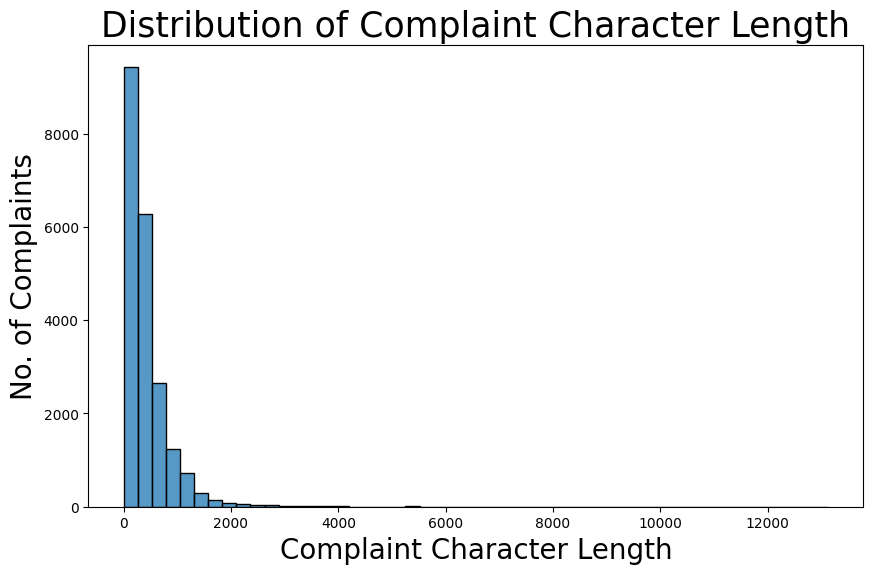

In [28]:
# Write your code here to visualise the data according to the 'Complaint' character length
plt.figure(figsize=[10,6])
sns.histplot(data = char_len,bins=50)
plt.title('Distribution of Complaint Character Length', fontsize=25)
plt.xlabel('Complaint Character Length',size=20)
plt.ylabel('No. of Complaints',size=20)
plt.show()

#### Find the top 40 words by frequency among all the articles after processing the text.

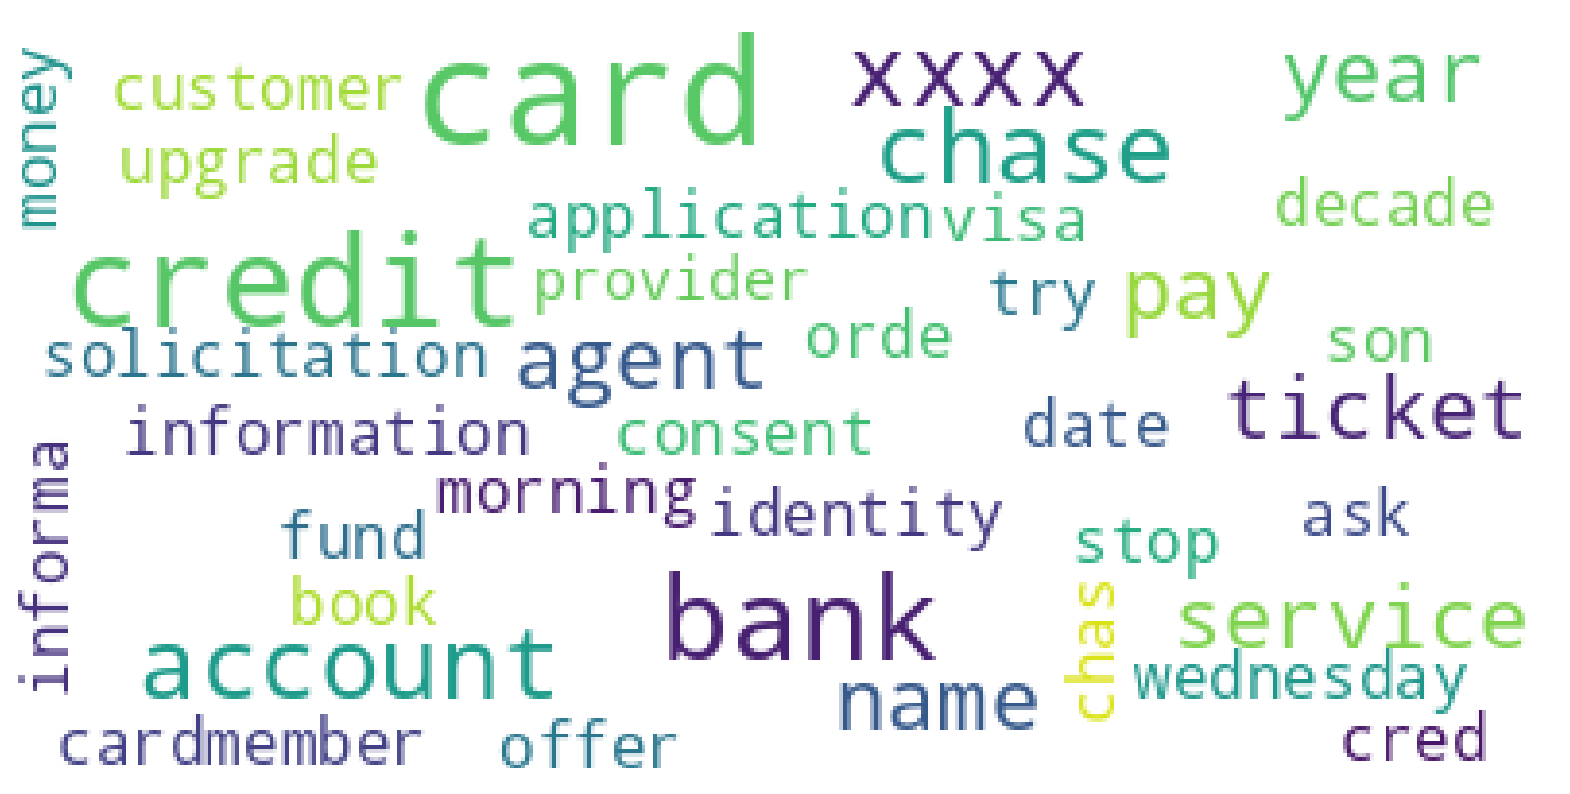

In [29]:
#Using a word cloud find the top 40 words by frequency among all the articles after processing the text
stop_words = set(STOPWORDS)
word_cloud = WordCloud(
                          background_color='white',
                          stopwords=stop_words,
                          max_font_size=38,
                          max_words=38,
                          random_state=42
                         ).generate(str(df_clean['complaint_POS_removed']))

fig = plt.figure(figsize=(20,16))
plt.imshow(word_cloud)
plt.axis('off')
plt.show()

In [30]:
#Removing -PRON- from the text corpus
df_clean.loc[:,'Complaint_clean'] = df_clean['complaint_POS_removed'].str.replace('-PRON-', '')

<ipython-input-30-be7fab8a5511>:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



#### Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text.

In [31]:
#Write your code here to find the top 30 unigram frequency among the complaints in the cleaned datafram(df_clean).

def get_top_unigram(text, n=30):
    vector = CountVectorizer(stop_words='english').fit(text)
    bag_of_words = vector.transform(text)
    sum_of_words = bag_of_words.sum(axis=0)
    word_freq = [(word, sum_of_words[0, idx]) for word, idx in vector.vocabulary_.items()]
    word_freq =sorted(word_freq, key = lambda x: x[1], reverse=True)
    return word_freq[:n]


In [32]:
#Print the top 10 words in the unigram frequency
top_common_words = get_top_unigram(df_clean['complaint_POS_removed'].values.astype('U'))
df_unigram = pd.DataFrame(top_common_words, columns = ['unigram' , 'count'])
df_unigram.head(10)

,unigram,count
0,chase,49092
1,account,47913
2,xxxx,43193
3,credit,34290
4,card,29611
5,bank,28501
6,payment,21337
7,time,16275
8,charge,15266
9,day,13074


In [33]:
#Write your code here to find the top 30 bigram frequency among the complaints in the cleaned datafram(df_clean).
def get_top_bigram(text, n=30):
    vector = CountVectorizer(ngram_range=(2, 2), stop_words='english').fit(text)
    bag_of_words = vector.transform(text)
    sum_of_words = bag_of_words.sum(axis=0)
    word_freq = [(word, sum_of_words[0, idx]) for word, idx in vector.vocabulary_.items()]
    word_freq =sorted(word_freq, key = lambda x: x[1], reverse=True)
    return word_freq[:n]

In [34]:
#Print the top 10 words in the bigram frequency
top_common_words = get_top_bigram(df_clean['complaint_POS_removed'].values.astype('U'))
df_bigram = pd.DataFrame(top_common_words, columns = ['bigram' , 'count'])
df_bigram.head(10)


,bigram,count
0,credit card,12873
1,xxxx xxxx,6299
2,credit report,3963
3,customer service,3082
4,chase credit,3049
5,chase bank,2955
6,account chase,2760
7,bank account,2755
8,chase account,2710
9,account account,2319


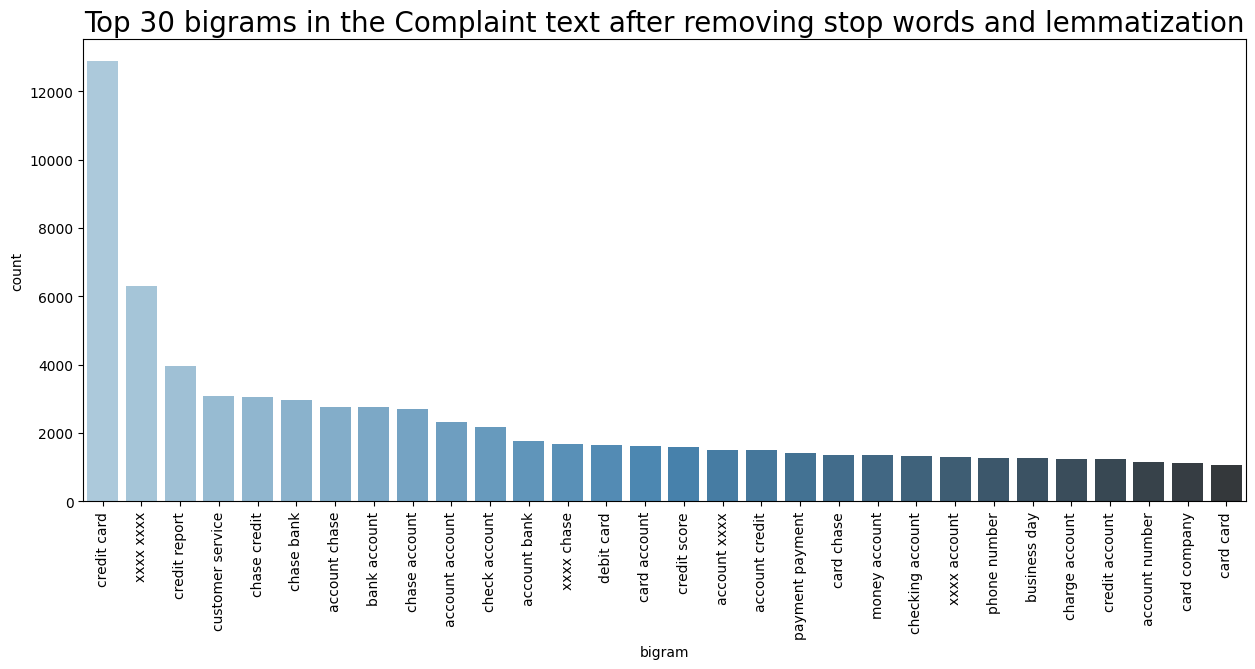

In [35]:
plt.figure(figsize=(15,6))
sns.barplot(x='bigram', y='count', data=df_bigram, palette="Blues_d")
plt.xticks(rotation=90)
plt.title("Top 30 bigrams in the Complaint text after removing stop words and lemmatization", fontsize=20)
plt.show()

In [36]:
#Write your code here to find the top 30 trigram frequency among the complaints in the cleaned datafram(df_clean).
def get_top_trigram(text, n=30):

    vector = CountVectorizer(ngram_range=(3, 3), stop_words='english').fit(text)
    bag_of_words = vector.transform(text)
    sum_of_words = bag_of_words.sum(axis=0)
    word_freq = [(word, sum_of_words[0, idx]) for word, idx in vector.vocabulary_.items()]
    word_freq =sorted(word_freq, key = lambda x: x[1], reverse=True)
    return word_freq[:n]

In [37]:
#Print the top 10 words in the trigram frequency
top_common_words = get_top_trigram(df_clean['complaint_POS_removed'].values.astype('U'))
df_trigram = pd.DataFrame(top_common_words, columns = ['trigram' , 'count'])
df_trigram.head(10)

,trigram,count
0,chase credit card,2130
1,xxxx xxxx xxxx,1094
2,credit card account,1056
3,credit card company,994
4,credit card chase,673
5,credit card credit,508
6,inquiry credit report,484
7,charge credit card,431
8,account credit card,416
9,card credit card,381


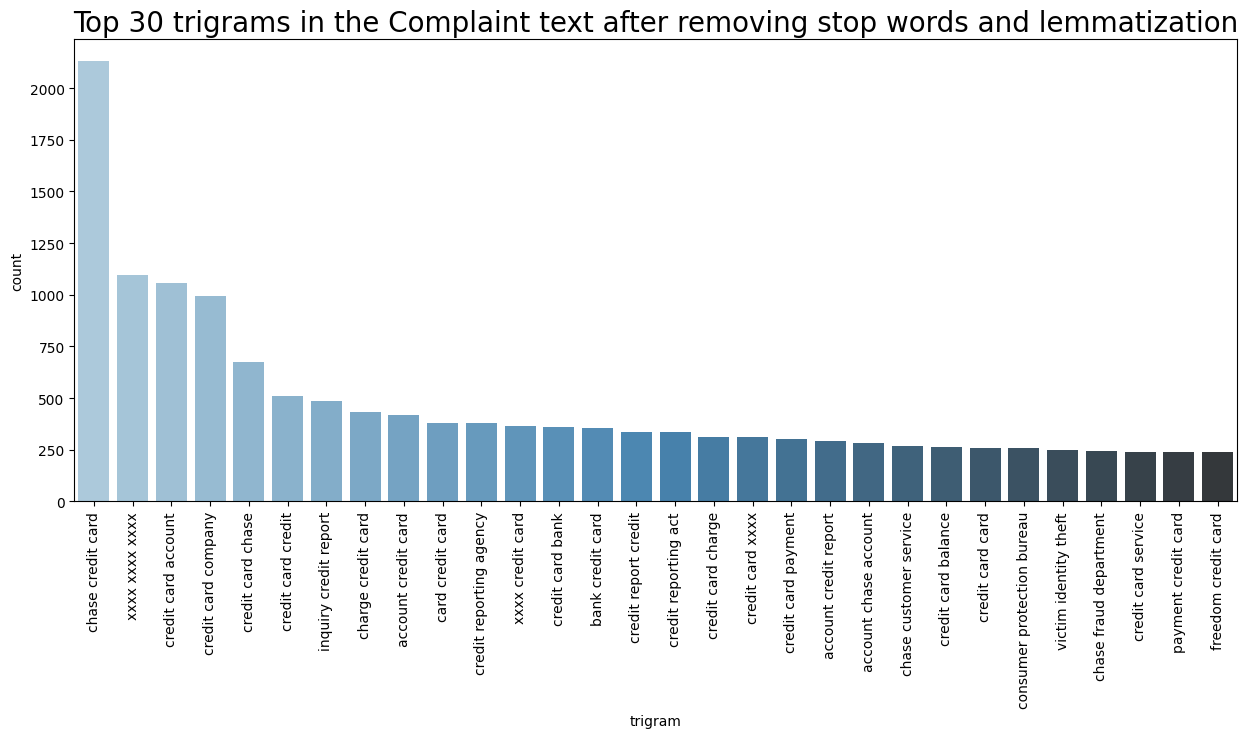

In [38]:
# Plot the top 30 unigrams
plt.figure(figsize=(15,6))
sns.barplot(x='trigram', y='count', data=df_trigram, palette="Blues_d")
plt.xticks(rotation=90)
plt.title("Top 30 trigrams in the Complaint text after removing stop words and lemmatization", fontsize=20)
plt.show()

## The personal details of customer has been masked in the dataset with xxxx. Let's remove the masked text as this will be of no use for our analysis

In [39]:
df_clean.head()

,lemmatized_complaint,complaint_what_happened,complaint_POS_removed,Complaint_clean
1,good morning my name be xxxx xxxx and I apprec...,good morning my name is xxxx xxxx and i apprec...,morning name stop bank cardmember service ask ...,morning name stop bank cardmember service ask ...
2,I upgrade my xxxx xxxx card in and be tell b...,i upgraded my xxxx xxxx card in and was told ...,card agent upgrade date agent information orde...,card agent upgrade date agent information orde...
10,"chase card be report on . however , fraudulent...","chase card was reported on . however, fraudule...",card application identity consent service cred...,card application identity consent service cred...
11,"on , while try to book a xxxx xxxx ticket ...","on , while trying to book a xxxx xxxx ticket...",try book xxxx ticket offer ticket card informa...,try book xxxx ticket offer ticket card informa...
14,my grand son give I check for I deposit it i...,my grand son give me check for i deposit it i...,son chase account fund bank account pay money ...,son chase account fund bank account pay money ...


In [40]:
df_clean['complaint_POS_removed'] = df_clean['complaint_POS_removed'].str.replace('xxxx','')

<ipython-input-40-76bef77f6cf6>:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [41]:
#All masked texts has been removed
df_clean

,lemmatized_complaint,complaint_what_happened,complaint_POS_removed,Complaint_clean
1,good morning my name be xxxx xxxx and I apprec...,good morning my name is xxxx xxxx and i apprec...,morning name stop bank cardmember service ask ...,morning name stop bank cardmember service ask ...
2,I upgrade my xxxx xxxx card in and be tell b...,i upgraded my xxxx xxxx card in and was told ...,card agent upgrade date agent information orde...,card agent upgrade date agent information orde...
10,"chase card be report on . however , fraudulent...","chase card was reported on . however, fraudule...",card application identity consent service cred...,card application identity consent service cred...
11,"on , while try to book a xxxx xxxx ticket ...","on , while trying to book a xxxx xxxx ticket...",try book ticket offer ticket card information...,try book xxxx ticket offer ticket card informa...
14,my grand son give I check for I deposit it i...,my grand son give me check for i deposit it i...,son chase account fund bank account pay money ...,son chase account fund bank account pay money ...
...,...,...,...,...
78303,after be a chase card customer for well over a...,after being a chase card customer for well ove...,card customer decade solicitation credit card ...,card customer decade solicitation credit card ...
78309,"on wednesday , I call chas , my xxxx xxxx vi...","on wednesday, i called chas, my xxxx xxxx vis...",wednesday chas visa credit card provider claim...,wednesday chas visa credit card provider claim...
78310,I be not familiar with xxxx pay and do not und...,i am not familiar with xxxx pay and did not un...,pay risk provide consumer bank app chase year ...,pay risk provide consumer bank app chase year ...
78311,I have have flawless credit for yrs . I 've ...,i have had flawless credit for yrs. i've had ...,credit yrs credit card chase freedom problem ...,credit yrs credit card chase freedom xxxx prob...


## Feature Extraction
Convert the raw texts to a matrix of TF-IDF features

**max_df** is used for removing terms that appear too frequently, also known as "corpus-specific stop words"
max_df = 0.95 means "ignore terms that appear in more than 95% of the complaints"

**min_df** is used for removing terms that appear too infrequently
min_df = 2 means "ignore terms that appear in less than 2 complaints"

In [42]:
#Write your code here to initialise the TfidfVectorizer
tfidf = TfidfVectorizer(max_df=0.95,min_df=2,stop_words='english')

#### Create a document term matrix using fit_transform

The contents of a document term matrix are tuples of (complaint_id,token_id) tf-idf score:
The tuples that are not there have a tf-idf score of 0

In [43]:
#Write your code here to create the Document Term Matrix by transforming the complaints column present in df_clean.
dtm = tfidf.fit_transform(df_clean['complaint_POS_removed'])

## Topic Modelling using NMF

Non-Negative Matrix Factorization (NMF) is an unsupervised technique so there are no labeling of topics that the model will be trained on. The way it works is that, NMF decomposes (or factorizes) high-dimensional vectors into a lower-dimensional representation. These lower-dimensional vectors are non-negative which also means their coefficients are non-negative.

In this task you have to perform the following:

* Find the best number of clusters
* Apply the best number to create word clusters
* Inspect & validate the correction of each cluster wrt the complaints
* Correct the labels if needed
* Map the clusters to topics/cluster names

## Manual Topic Modeling
You need to do take the trial & error approach to find the best num of topics for your NMF model.

The only parameter that is required is the number of components i.e. the number of topics we want. This is the most crucial step in the whole topic modeling process and will greatly affect how good your final topics are.

In [44]:
#Load your nmf_model with the n_components i.e 5
num_topics = 5

#keep the random_state =40
nmf_model = NMF(random_state=40, n_components=num_topics)

In [45]:
nmf_model.fit(dtm)
len(tfidf.get_feature_names_out())

7063

In [46]:
#Print the Top15 words for each of the topics
words = np.array(tfidf.get_feature_names_out())
topic_words_df = pd.DataFrame(np.zeros((num_topics, 15)), index=[f'Topic {i + 1}' for i in range(num_topics)],
                           columns=[f'Word {i + 1}' for i in range(15)]).astype(str)

for i in range(num_topics):
    ix = nmf_model.components_[i].argsort()[::-1][:15]
    topic_words_df.iloc[i] = words[ix]

topic_words_df


,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14,Word 15
Topic 1,account,check,bank,money,fund,chase,deposit,branch,day,number,business,transaction,claim,transfer,customer
Topic 2,credit,card,report,inquiry,chase,account,score,company,limit,information,debt,application,letter,balance,year
Topic 3,payment,balance,month,fee,statement,auto,day,time,pay,date,credit,account,chase,year,mortgage
Topic 4,charge,card,fee,chase,dispute,transaction,merchant,purchase,fraud,claim,service,time,refund,statement,company
Topic 5,loan,mortgage,home,chase,modification,property,year,letter,rate,time,document,bank,foreclosure,house,sale


In [47]:
#Create the best topic for each complaint in terms of integer value 0,1,2,3 & 4
topic_results = nmf_model.transform(dtm)
topic_results.argmax(axis=1)

array([4, 1, 1, ..., 3, 2, 2])

In [48]:
#Assign the best topic to each of the cmplaints in Topic Column
df_clean['Topic'] = topic_results.argmax(axis=1)

<ipython-input-48-fe27c2f4cb3a>:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [49]:
df_clean.head()

,lemmatized_complaint,complaint_what_happened,complaint_POS_removed,Complaint_clean,Topic
1,good morning my name be xxxx xxxx and I apprec...,good morning my name is xxxx xxxx and i apprec...,morning name stop bank cardmember service ask ...,morning name stop bank cardmember service ask ...,4
2,I upgrade my xxxx xxxx card in and be tell b...,i upgraded my xxxx xxxx card in and was told ...,card agent upgrade date agent information orde...,card agent upgrade date agent information orde...,1
10,"chase card be report on . however , fraudulent...","chase card was reported on . however, fraudule...",card application identity consent service cred...,card application identity consent service cred...,1
11,"on , while try to book a xxxx xxxx ticket ...","on , while trying to book a xxxx xxxx ticket...",try book ticket offer ticket card information...,try book xxxx ticket offer ticket card informa...,1
14,my grand son give I check for I deposit it i...,my grand son give me check for i deposit it i...,son chase account fund bank account pay money ...,son chase account fund bank account pay money ...,0


In [50]:
#Print the first 5 Complaint for each of the Topics
First5_comp=df_clean.groupby('Topic').head(5)
First5_comp.sort_values('Topic')

,lemmatized_complaint,complaint_what_happened,complaint_POS_removed,Complaint_clean,Topic
14,my grand son give I check for I deposit it i...,my grand son give me check for i deposit it i...,son chase account fund bank account pay money ...,son chase account fund bank account pay money ...,0
17,with out notice j.p . morgan chase restrict my...,with out notice j.p. morgan chase restricted m...,j.p chase account debit card tuesday thursday ...,j.p chase account debit card tuesday thursday ...,0
24,mishandle of this account by chase auto and xx...,mishandling of this account by chase auto and ...,mishandle account auto,mishandle account auto xxxx,0
27,I open an account with chase bank on xxxx and ...,i opened an account with chase bank on xxxx an...,account bank code bonus term everything accoun...,account bank code bonus term everything accoun...,0
35,I open the save account for the bonus . I be...,i opened the saving account for the bonus. i ...,save account bonus bonus auto transfer check t...,save account bonus bonus auto transfer check t...,0
2,I upgrade my xxxx xxxx card in and be tell b...,i upgraded my xxxx xxxx card in and was told ...,card agent upgrade date agent information orde...,card agent upgrade date agent information orde...,1
10,"chase card be report on . however , fraudulent...","chase card was reported on . however, fraudule...",card application identity consent service cred...,card application identity consent service cred...,1
11,"on , while try to book a xxxx xxxx ticket ...","on , while trying to book a xxxx xxxx ticket...",try book ticket offer ticket card information...,try book xxxx ticket offer ticket card informa...,1
15,can you please remove inquiry,can you please remove inquiry,inquiry,inquiry,1
23,I have a chase credit card which be incorrectl...,i have a chase credit card which is incorrectl...,chase credit card datum credit report company ...,chase credit card datum credit report company ...,1


#### After evaluating the mapping, if the topics assigned are correct then assign these names to the relevant topic:
* Bank Account services
* Credit card or prepaid card
* Theft/Dispute Reporting
* Mortgage/Loan
* Others

In [51]:
# Create the dictionary of Topic names and Topics
Topic_names = {0:'Account Services', 1:'Others', 2:'Mortgage/Loan', 3:'Credit card or prepaid card', 4:'Theft/Dispute Reporting'}

# Replace Topics with Topic Names
df_clean['Topic'] = df_clean['Topic'].map(Topic_names)

<ipython-input-51-5594de1bfd41>:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [52]:
df_clean

,lemmatized_complaint,complaint_what_happened,complaint_POS_removed,Complaint_clean,Topic
1,good morning my name be xxxx xxxx and I apprec...,good morning my name is xxxx xxxx and i apprec...,morning name stop bank cardmember service ask ...,morning name stop bank cardmember service ask ...,Theft/Dispute Reporting
2,I upgrade my xxxx xxxx card in and be tell b...,i upgraded my xxxx xxxx card in and was told ...,card agent upgrade date agent information orde...,card agent upgrade date agent information orde...,Others
10,"chase card be report on . however , fraudulent...","chase card was reported on . however, fraudule...",card application identity consent service cred...,card application identity consent service cred...,Others
11,"on , while try to book a xxxx xxxx ticket ...","on , while trying to book a xxxx xxxx ticket...",try book ticket offer ticket card information...,try book xxxx ticket offer ticket card informa...,Others
14,my grand son give I check for I deposit it i...,my grand son give me check for i deposit it i...,son chase account fund bank account pay money ...,son chase account fund bank account pay money ...,Account Services
...,...,...,...,...,...
78303,after be a chase card customer for well over a...,after being a chase card customer for well ove...,card customer decade solicitation credit card ...,card customer decade solicitation credit card ...,Others
78309,"on wednesday , I call chas , my xxxx xxxx vi...","on wednesday, i called chas, my xxxx xxxx vis...",wednesday chas visa credit card provider claim...,wednesday chas visa credit card provider claim...,Credit card or prepaid card
78310,I be not familiar with xxxx pay and do not und...,i am not familiar with xxxx pay and did not un...,pay risk provide consumer bank app chase year ...,pay risk provide consumer bank app chase year ...,Credit card or prepaid card
78311,I have have flawless credit for yrs . I 've ...,i have had flawless credit for yrs. i've had ...,credit yrs credit card chase freedom problem ...,credit yrs credit card chase freedom xxxx prob...,Mortgage/Loan


## Supervised model to predict any new complaints to the relevant Topics.

You have now build the model to create the topics for each complaints.Now in the below section you will use them to classify any new complaints.

Since you will be using supervised learning technique we have to convert the topic names to numbers(numpy arrays only understand numbers)

In [53]:
# Create the dictionary again of Topic names and Topics

Topic_names = {'Account Services':0, 'Others':1, 'Mortgage/Loan':2, 'Credit card or prepaid card':3, 'Theft/Dispute Reporting':4}
# Replace Topics with Topic Names
df_clean['Topic'] = df_clean['Topic'].map(Topic_names)


<ipython-input-53-421175598d20>:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [54]:
df_clean.head()

,lemmatized_complaint,complaint_what_happened,complaint_POS_removed,Complaint_clean,Topic
1,good morning my name be xxxx xxxx and I apprec...,good morning my name is xxxx xxxx and i apprec...,morning name stop bank cardmember service ask ...,morning name stop bank cardmember service ask ...,4
2,I upgrade my xxxx xxxx card in and be tell b...,i upgraded my xxxx xxxx card in and was told ...,card agent upgrade date agent information orde...,card agent upgrade date agent information orde...,1
10,"chase card be report on . however , fraudulent...","chase card was reported on . however, fraudule...",card application identity consent service cred...,card application identity consent service cred...,1
11,"on , while try to book a xxxx xxxx ticket ...","on , while trying to book a xxxx xxxx ticket...",try book ticket offer ticket card information...,try book xxxx ticket offer ticket card informa...,1
14,my grand son give I check for I deposit it i...,my grand son give me check for i deposit it i...,son chase account fund bank account pay money ...,son chase account fund bank account pay money ...,0


In [55]:
# Keep the columns"complaint_what_happened" & "Topic" only in the new dataframe --> training_data
training_data = df_clean.drop(['lemmatized_complaint', 'complaint_POS_removed', 'Complaint_clean'], axis=1)


In [56]:
training_data.head()

,complaint_what_happened,Topic
1,good morning my name is xxxx xxxx and i apprec...,4
2,i upgraded my xxxx xxxx card in and was told ...,1
10,"chase card was reported on . however, fraudule...",1
11,"on , while trying to book a xxxx xxxx ticket...",1
14,my grand son give me check for i deposit it i...,0


####Apply the supervised models on the training data created. In this process, you have to do the following:
* Create the vector counts using Count Vectoriser
* Transform the word vecotr to tf-idf
* Create the train & test data using the train_test_split on the tf-idf & topics


In [57]:
# Write your code to get the Vector count
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(training_data.complaint_what_happened)

# Write your code here to transform the word vector to tf-idf
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)


In [58]:
pickle.dump(count_vect.vocabulary_,open("count_vect.pkl","wb"))
pickle.dump(tfidf_transformer, open("tfidf.pkl","wb"))

You have to try atleast 3 models on the train & test data from these options:
* Logistic regression
* Decision Tree
* Random Forest
* Naive Bayes (optional)

**Using the required evaluation metrics judge the tried models and select the ones performing the best**

In [59]:
# Split data into train and test
X_train, X_test, y_train, y_test = train_test_split(X_train_tfidf, training_data.Topic, test_size=0.2, random_state=42)
print(f"X_train Shape: {X_train.shape}")
print(f"y_train Shape: {y_train.shape}")
print(f"X_test Shape: {X_test.shape}")
print(f"y_test Shape: {y_test.shape}")

X_train Shape: (16857, 27760)
y_train Shape: (16857,)
X_test Shape: (4215, 27760)
y_test Shape: (4215,)


Logistic Regression

In [60]:
# Logistic Regression
model_name = 'LOGISTIC REGRESSION'
lr = LogisticRegression().fit(X_train, y_train)
predicted = lr.predict(X_test)

print(classification_report(y_true=y_test, y_pred=predicted))

              precision    recall  f1-score   support

           0       0.91      0.95      0.93      1044
           1       0.92      0.94      0.93      1037
           2       0.96      0.87      0.91       445
           3       0.90      0.90      0.90       970
           4       0.94      0.93      0.94       719

    accuracy                           0.92      4215
   macro avg       0.93      0.92      0.92      4215
weighted avg       0.92      0.92      0.92      4215



/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



In [70]:
# Hyperparameter tuning for best result
param_lr = {
    'penalty': ['l1', 'l2'],
    'C': [0.01,0.1,1],
    'solver':['liblinear', 'saga']
}

grid_lr = GridSearchCV(estimator=lr,
                       param_grid=param_lr,
                       verbose=1,
                       scoring='f1_weighted',
                       n_jobs=-1,
                       cv=5)
grid_lr.fit(X_train, y_train)
print(grid_lr.best_params_)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
{'C': 1, 'penalty': 'l1', 'solver': 'saga'}


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge



In [62]:
# Creating model with best hyperparameter
lr_tuned = LogisticRegression(C=1,
                                  penalty='l1',
                                  solver='saga')

lr_tuned.fit(X_train, y_train)
y_pred_lr_tuned = lr_tuned.predict(X_test)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge



Naive Bayes

In [63]:
# Run the Multinomial Naive Bayes with default parameters
model_name = 'NAIVE BAYES'
nb = MultinomialNB()
nb.fit(X_train, y_train)
y_pred_nb = nb.predict(X_test)

In [64]:
# Hyperparameter tuning for best result
param_nb = {
    'alpha': (1, 0.1, 0.01, 0.001),
    'fit_prior':[True, False]
}

grid_nb = GridSearchCV(estimator=nb,
                       param_grid=param_nb,
                       verbose=1,
                       scoring='f1_weighted',
                       n_jobs=-1,
                       cv=10)
grid_nb.fit(X_train, y_train)
print(grid_nb.best_params_)

Fitting 10 folds for each of 8 candidates, totalling 80 fits
{'alpha': 0.1, 'fit_prior': False}


In [65]:
nb_tuned = MultinomialNB(alpha=0.1,fit_prior=False)
nb_tuned.fit(X_train, y_train)
y_pred_nb_tuned = nb_tuned.predict(X_test)

Decision Tree

In [66]:
# Run Decision Tree with default hyperparameters
model_name = 'DECISION TREE'
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)
y_pred_dt =dt.predict(X_test)


In [67]:
# Hyperparameter tuning for best result
param_dt = {
    'criterion': ['gini', 'entropy'],
    'max_depth' : [10, 15, 20, 25, 30],
    'min_samples_leaf':[5,10,15, 20],

}

grid_dt = GridSearchCV(estimator=dt,
                       param_grid=param_dt,
                       verbose=1,
                       scoring='f1_weighted',
                       n_jobs=-1,
                       cv=5)
grid_dt.fit(X_train, y_train)
print(grid_dt.best_params_)

Fitting 5 folds for each of 40 candidates, totalling 200 fits
{'criterion': 'gini', 'max_depth': 30, 'min_samples_leaf': 20}


In [69]:
# Creating model with best hyperparameter
dt_tuned = DecisionTreeClassifier(criterion='gini',
                                      max_depth=30,
                                      min_samples_leaf=20,
                                      )
dt_tuned.fit(X_train, y_train)
y_pred_dt_tuned = dt_tuned.predict(X_test)

Random Forest Classifier

In [ ]:
rfc = RandomForestClassifier(max_depth=10)
rfc.fit(X_train, y_train)
predicted = rfc.predict(X_test)

print(classification_report(y_pred=predicted, y_true=y_test))

              precision    recall  f1-score   support

           0       0.76      0.90      0.82      1009
           1       0.70      0.82      0.76      1003
           2       0.85      0.77      0.80       736
           3       0.71      0.81      0.76      1033
           4       1.00      0.03      0.05       434

    accuracy                           0.74      4215
   macro avg       0.80      0.66      0.64      4215
weighted avg       0.77      0.74      0.71      4215



In [ ]:
def predict_lr(text):
    Topic_names = {0:'Account Services', 1:'Others', 2:'Mortgage/Loan', 3:'Credit card or prepaid card', 4:'Theft/Dispute Reporting'}
    X_new_counts = count_vect.transform(text)
    X_new_tfidf = tfidf_transformer.transform(X_new_counts)
    predicted = lr.predict(X_new_tfidf)
    return Topic_names[predicted[0]]

In [ ]:
df_complaints['tag'] = df_complaints['complaints'].apply(lambda x: predict_lr([x]))
df_complaints

,complaints,tag
0,I can not get from chase who services my mortg...,Mortgage/Loan
1,The bill amount of my credit card was debited ...,Others
2,I want to open a salary account at your downto...,Account Services
3,"Yesterday, I received a fraudulent email regar...",Credit card or prepaid card
4,What is the procedure to know my CIBIL score?,Others
5,I need to know the number of bank branches and...,Account Services
